In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers



In [3]:
def load_images_from_folder(folder,eyes):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        img=cv2.resize(img,(80,80))
        images.append([img,eyes])
    return images

In [4]:

folder="/content/drive/MyDrive/train/Open_Eyes"
open_eyes=load_images_from_folder(folder,0)

folder="/content/drive/MyDrive/train/Closed_Eyes"
closed_eyes=load_images_from_folder(folder,1)


In [5]:
#Number of Images
#
print(len(open_eyes))
print(len(closed_eyes))

2000
2000


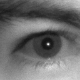

In [6]:
#Displaying image to confirm that they have been loaded 
from PIL import Image as im
data=im.fromarray(open_eyes[0][0])
data

In [7]:
#Combining the open and closed eye data 
eyes=open_eyes+closed_eyes

In [8]:
#Setting up images with X being images and y being labels
X=[]
y=[]

for features, label in eyes:
    X.append(features)
    y.append(label)



In [9]:
#Converting image to array for modelling and scaling by dividing by 255
X=np.array(X).reshape(-1,80,80,3)
y=np.array(y)
X=X/255.0

In [10]:
# Splitting the data 

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=23 )


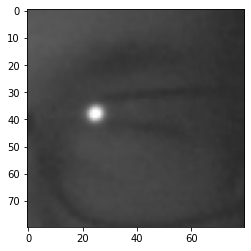

In [11]:
#confirming that split ran okay

plt.figure()
plt.imshow(X_train[10])
plt.show()

In [12]:
#class names for images shown below 

class_names=['open','close']

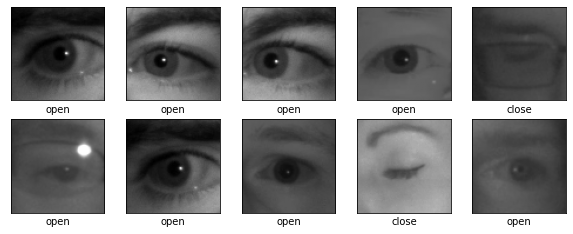

In [13]:
#producing images of training set with corresponding label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

In [14]:
#Reshping imags to 80*80*3 just incase 
X_train=X_train.reshape(X_train.shape[0], 80,80,3)
X_test=X_test.reshape(X_test.shape[0], 80,80,3)

In [15]:
def deep_learning_model(dense_neurons1=128,dense_neurons2=128,dense_neurons3=128,layout='',filters=32,dropout=None,pooling=None):
  model=Sequential()
  if layout== '5x5':
    model.add(Conv2D(filters=filters, kernel_size=(5,5),activation='relu',input_shape=(80,80,3)))

  if layout=='3x3'or layout== '2*3x3':
    model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))

#adding pooling for convlutional layers
  if pooling!=None:
    model.add(MaxPooling2D(pool_size=(2,2)))

  if layout=='2*3x3':
    #second layer
      model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
#adding pooling on 2*3x3
  if pooling !=None and layout =='2*3x3':
    model.add(MaxPooling2D(pool_size=(2,2)))

#flatten model for dense layers
  model.add(Flatten())
  model.add(Dense(dense_neurons1,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons2,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons3,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))

#adding output layer

  model.add(Dense(1,activation='sigmoid'))

  #compiling using binary cross entropy and using AUC as metric 
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.AUC(curve='PR')])

  return model







    


In [16]:
early_stop=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=.05)

In [17]:
params_deep={
    "layout":['3x3','5x5','2*3x3'],
    "dense_neurons1":[64,128],
    'filters':[8,18,32],
    "dropout":[0.1,0.5,],
    "pooling":[None,1],
    "epochs":[10]

}

In [18]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep,cv=3,scoring='average_precision')
gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/10
10/10 [==============================] - 13s 73ms/step - loss: 0.9834 - auc: 0.5487 - val_loss: 0.5854 - val_auc: 0.8962
Epoch 2/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5507 - auc: 0.7827 - val_loss: 0.4170 - val_auc: 0.9487
Epoch 3/10
10/10 [==============================] - 0s 27ms/step - loss: 0.3536 - auc: 0.9315 - val_loss: 0.2487 - val_auc: 0.9615
Epoch 4/10
10/10 [==============================] - 0s 28ms/step - loss: 0.2580 - auc: 0.9555 - val_loss: 0.2349 - val_auc: 0.9708
Epoch 5/10
10/10 [==============================] - 0s 29ms/step - loss: 0.2065 - auc: 0.9678 - val_loss: 0.1628 - val_auc: 0.9775
Epoch 6/10
10/10 [==============================] - 0s 27ms/step - loss: 0.1574 - auc: 0.9817 - val_loss: 0.1176 - val_auc: 0.9850
Epoch 7/10
10/10 [==============================] - 0s 27ms/step - loss: 0.1285 - auc: 0.9868 - val_loss: 0.0980 - val_auc: 0.9875
Epoch 8/10
10/10 [==============================] - 0s 27ms/step - loss: 0.1058 - 

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7be855f610>,
             param_grid={'dense_neurons1': [64, 128], 'dropout': [0.1, 0.5],
                         'epochs': [10], 'filters': [8, 18, 32],
                         'layout': ['3x3', '5x5', '2*3x3'],
                         'pooling': [None, 1]},
             scoring='average_precision')

In [24]:


#Summary of thescores

means = gs_deep.cv_results_['mean_test_score']
stds = gs_deep.cv_results_['std_test_score']
params = gs_deep.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')


 mean=0.9941, std=0.0006564 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 8, 'layout': '3x3', 'pooling': None}
 mean=0.9908, std=0.003524 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 8, 'layout': '3x3', 'pooling': 1}
 mean=0.9991, std=0.0003294 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 8, 'layout': '5x5', 'pooling': None}
 mean=0.9943, std=0.001179 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 8, 'layout': '5x5', 'pooling': 1}
 mean=0.9962, std=0.003162 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 8, 'layout': '2*3x3', 'pooling': None}
 mean=0.9944, std=0.002882 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 8, 'layout': '2*3x3', 'pooling': 1}
 mean=0.9982, std=0.0002314 using {'dense_neurons1': 64, 'dropout': 0.1, 'epochs': 10, 'filters': 18, 'layout': '3x3', 'pooling': None}
 mean=0.9939, std=0.001651 using {'dense_neurons1': 64, 'dropou

In [25]:
print(f'Best Accuracy for {gs_deep.best_score_} using {gs_deep.best_params_}')


Best Accuracy for 0.999472216392248 using {'dense_neurons1': 128, 'dropout': 0.5, 'epochs': 10, 'filters': 32, 'layout': '2*3x3', 'pooling': 1}


From this grid search we find the best layout to be 2*3x3 with 32 filters. This means we will have two convolution layers with a kernel size of (3,3) representing the height and width of the filter. We will perform other iterations on the same layout but with three layers of dense neurons and different hyperparameters.

In [26]:
params_deep_two={
    "layout":['2*3x3'],
    "dense_neurons1":[128,256],
    "dense_neurons2":[256,512],
    "dense_neurons3":[256,512],
    'filters':[32],
    "dropout":[0,0.1,0.3,0.5,],
    "pooling":[None,1],
    "epochs":[20]

}

In [27]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep_two,cv=3,scoring='average_precision')
gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/20
10/10 [==============================] - 2s 115ms/step - loss: 1.6615 - auc_217: 0.5395 - val_loss: 0.7457 - val_auc_217: 0.4628
Epoch 2/20
10/10 [==============================] - 1s 73ms/step - loss: 0.6618 - auc_217: 0.6852 - val_loss: 0.5163 - val_auc_217: 0.9024
Epoch 3/20
10/10 [==============================] - 1s 74ms/step - loss: 0.4299 - auc_217: 0.8852 - val_loss: 0.3213 - val_auc_217: 0.9621
Epoch 4/20
10/10 [==============================] - 1s 72ms/step - loss: 0.2551 - auc_217: 0.9579 - val_loss: 0.1592 - val_auc_217: 0.9884
Epoch 5/20
10/10 [==============================] - 1s 73ms/step - loss: 0.1280 - auc_217: 0.9892 - val_loss: 0.0828 - val_auc_217: 0.9960
Epoch 6/20
10/10 [==============================] - 1s 72ms/step - loss: 0.0665 - auc_217: 0.9977 - val_loss: 0.0389 - val_auc_217: 0.9989
Epoch 7/20
10/10 [==============================] - 1s 77ms/step - loss: 0.0393 - auc_217: 0.9989 - val_loss: 0.0276 - val_auc_217: 0.9994
Epoch 8/20
10/10 [========

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7b3e666d10>,
             param_grid={'dense_neurons1': [128, 256],
                         'dense_neurons2': [256, 512],
                         'dense_neurons3': [256, 512],
                         'dropout': [0, 0.1, 0.3, 0.5], 'epochs': [20],
                         'filters': [32], 'layout': ['2*3x3'],
                         'pooling': [None, 1]},
             scoring='average_precision')

In [28]:
#Summary of the results
means = gs_deep.cv_results_['mean_test_score']
stds = gs_deep.cv_results_['std_test_score']
params = gs_deep.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

 mean=0.9994, std=0.0005319 using {'dense_neurons1': 128, 'dense_neurons2': 256, 'dense_neurons3': 256, 'dropout': 0, 'epochs': 20, 'filters': 32, 'layout': '2*3x3', 'pooling': None}
 mean=0.9981, std=0.001151 using {'dense_neurons1': 128, 'dense_neurons2': 256, 'dense_neurons3': 256, 'dropout': 0, 'epochs': 20, 'filters': 32, 'layout': '2*3x3', 'pooling': 1}
 mean=0.9997, std=0.0001265 using {'dense_neurons1': 128, 'dense_neurons2': 256, 'dense_neurons3': 256, 'dropout': 0.1, 'epochs': 20, 'filters': 32, 'layout': '2*3x3', 'pooling': None}
 mean=0.9997, std=0.0001464 using {'dense_neurons1': 128, 'dense_neurons2': 256, 'dense_neurons3': 256, 'dropout': 0.1, 'epochs': 20, 'filters': 32, 'layout': '2*3x3', 'pooling': 1}
 mean=0.9993, std=0.0005862 using {'dense_neurons1': 128, 'dense_neurons2': 256, 'dense_neurons3': 256, 'dropout': 0.3, 'epochs': 20, 'filters': 32, 'layout': '2*3x3', 'pooling': None}
 mean=0.9996, std=0.0004173 using {'dense_neurons1': 128, 'dense_neurons2': 256, 'dens

In [29]:
print(f'Best Accuracy for {gs_deep.best_score_} using {gs_deep.best_params_}')

Best Accuracy for 0.9998397543919476 using {'dense_neurons1': 256, 'dense_neurons2': 512, 'dense_neurons3': 512, 'dropout': 0.3, 'epochs': 20, 'filters': 32, 'layout': '2*3x3', 'pooling': 1}


Given that we have an accuracy of 0.998397543919476, which is better than the neural network architecture with one dense layer at 0.999472216392248  , we can take these as the  parameters to build our final model.

Final model for Export

AUC score of model produced by grid search: 0.9998397543919476

Parameters of best model produced by grid search:

dense_neurons1: 256,
dense_neurons2: 512,
dense_neurons3: 512, 
dropout: 0.3, 
epochs: 20, 
filters: 32, 
layout: '2*3x3', 
pooling: 1




In [31]:
#instantiate the model
model=Sequential()

#adding first convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
#maxpooling after convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

#adding another convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
#maxpooling after convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#adding first dense layer with 256 nodes
model.add(Dense(256, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#adding second dense layer with 512 nodes
model.add(Dense(512, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#adding third dense layer with 512 nodes
model.add(Dense(512, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#Output layer
model.add(Dense(1, activation='sigmoid'))
#compiling 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])

#fitting on train data
model.fit(X_train,y_train,batch_size=200, epochs=20)

Epoch 1/20
15/15 [==============================] - 1s 35ms/step - loss: 0.5630 - auc_410: 0.7659
Epoch 2/20
15/15 [==============================] - 0s 31ms/step - loss: 0.2784 - auc_410: 0.9481
Epoch 3/20
15/15 [==============================] - 0s 31ms/step - loss: 0.1361 - auc_410: 0.9831
Epoch 4/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0794 - auc_410: 0.9926
Epoch 5/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0486 - auc_410: 0.9983
Epoch 6/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0438 - auc_410: 0.9985
Epoch 7/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0334 - auc_410: 0.9992
Epoch 8/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0115 - auc_410: 0.9999
Epoch 9/20
15/15 [==============================] - 0s 30ms/step - loss: 0.0061 - auc_410: 1.0000
Epoch 10/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0047 - auc_410: 1.0000
Epoch 11/20
15/15 [

In [32]:
model.summary()

Model: "sequential_410"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_676 (Conv2D)         (200, 78, 78, 32)         896       
                                                                 
 max_pooling2d_340 (MaxPooli  (200, 39, 39, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_677 (Conv2D)         (200, 37, 37, 32)         9248      
                                                                 
 max_pooling2d_341 (MaxPooli  (200, 18, 18, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_410 (Flatten)       (200, 10368)              0         
                                                                 
 dense_1640 (Dense)          (200, 256)             

In [33]:
#Evaluating model on test data
score=model.evaluate(X_test,y_test, verbose=1)

labels=model.metrics_names

#showing perfomance
print(f'{labels[0]}: {score[0]}')

print(f'{labels[1]}: {score[1]}')

32/32 [==============================] - 1s 5ms/step - loss: 2.6295e-04 - auc_410: 1.0000
loss: 0.00026294687995687127
auc_410: 1.0


In [34]:
preds=model.predict(X_test)
preds.round(1)
preds

array([[1.41295029e-08],
       [1.00000000e+00],
       [1.21931769e-23],
       [9.99989390e-01],
       [9.99999762e-01],
       [7.29317367e-02],
       [1.00000000e+00],
       [3.31779559e-19],
       [4.74774931e-03],
       [2.25462616e-23],
       [9.99997735e-01],
       [1.00000000e+00],
       [5.38318454e-06],
       [2.09816426e-06],
       [2.28662556e-09],
       [9.99995947e-01],
       [6.92149335e-22],
       [9.99999881e-01],
       [2.79224719e-06],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.39362794e-06],
       [2.47188914e-24],
       [9.99999523e-01],
       [1.22730928e-08],
       [2.18570865e-12],
       [8.38422478e-27],
       [1.00000000e+00],
       [9.99994636e-01],
       [3.01790259e-09],
       [9.99996662e-01],
       [8.75636173e-23],
       [9.99999285e-01],
       [9.99996901e-01],
       [9.68084751e-22],
       [1.10540567e-22],
       [6.23298035e-08],
       [1.00000000e+00],
       [1.00000000e+00],


In [36]:
confusion_matrix=tf.math.confusion_matrix(labels=y_test,predictions=preds.round()).numpy()

confusion_matrix

array([[510,   0],
       [  0, 490]], dtype=int32)

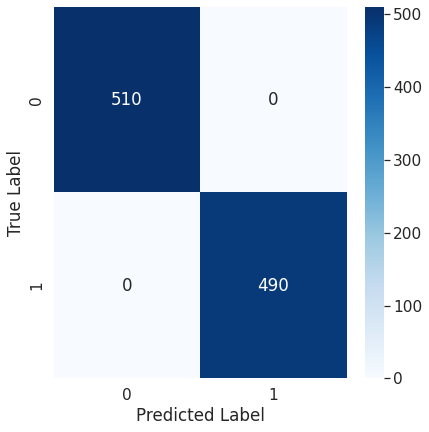

In [37]:
import seaborn as sns 
figure =plt.figure(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix,annot=True,cmap=plt.cm.Blues,fmt='g')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
tn, fp, fn, tp =confusion_matrix.ravel()

In [41]:
#Calculating recall
recall=tp/(tp+fp)
print(f'recall: {recall}')
#Calculating precision
precision=tp/(tp+fn)
print(f'precision: {precision}')
#Calculating f1-score
f1_score=(precision*recall)/(precision+recall)
print(f'f1_score: {f1_score}')
#Calculating accuracy
accuracy=(tn+tp)/(tn+fp+fn+tp)
print(f'accuracy: {accuracy}')

recall: 1.0
precision: 1.0
f1_score: 0.5
accuracy: 1.0


In [ ]:
#Saving the best model
